In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')   #other.data becuase other is a Class Value other

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward

        return out                                                  #we need data atribute of this other instance

    def __neg__(self):
        return self*-1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):  # Handles float - Value
      return Value(other) - self


    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')    # self is the instance, here a will be the self and b will be other

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only suppoting int and float power"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self*other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2)*out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo=[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()



In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

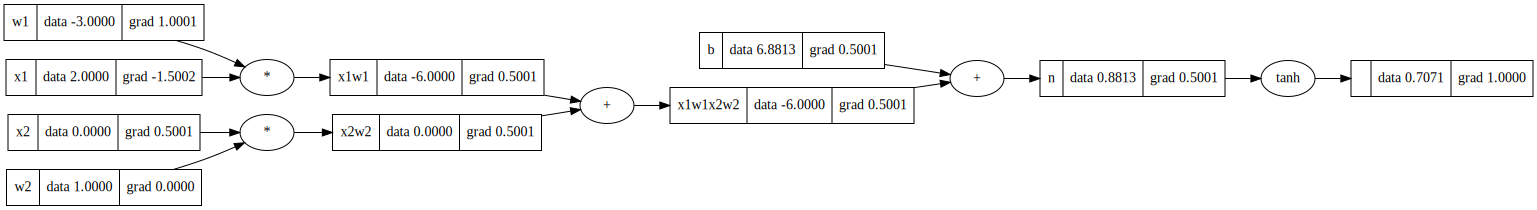

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

o.backward()

draw_dot(o)

In [ ]:

print(o.grad)

print(n.grad)


print(x1w1.grad)
print(x2w2.grad)

print(x1.grad)
print(w1.grad)


print(x2.grad)
print(w2.grad)

1.0
0.5000520352341944
0.5000520352341944
0.5000520352341944
-1.5001561057025832
1.0001040704683888
0.5000520352341944
0.0


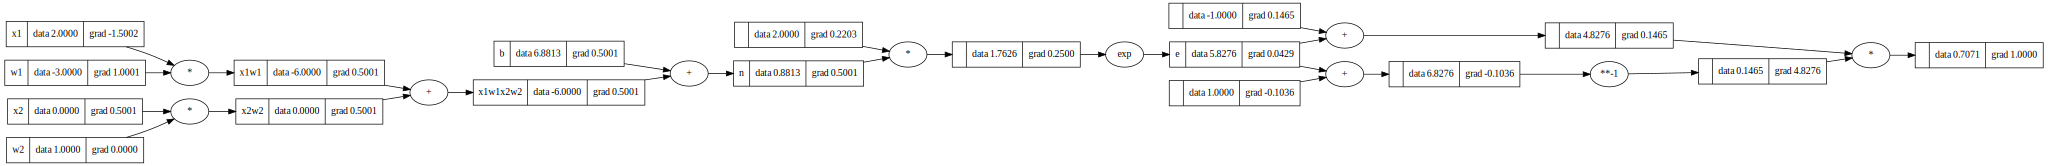

In [ ]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label='e'

o = (e-1)/(e+1)

o.backward()

draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()   ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ;w2.requires_grad = True
b = torch.Tensor([6.8813]).double() ;b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)
o.backward()

print(w2.grad)
print(x2.grad)
print(x1.grad)
print(w1.grad)

tensor([0.], dtype=torch.float64)
tensor([0.5001], dtype=torch.float64)
tensor([-1.5002], dtype=torch.float64)
tensor([1.0001], dtype=torch.float64)


In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self,nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [ ]:

n = MLP(3, [4, 4, 1])


In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(50):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yp-yss)**2 for yss, yp in zip(ys, ypred))

  for p in n.parameters():
    p.grad = 0.0

  #backward pass
  loss.backward()
  #print(n.layers[0].neurons[0].b.grad)

  for p in n.parameters():
    p.data += -0.06*p.grad

  print(k, loss.data)


0 0.15537746742747127
1 0.132492341956259
2 0.11518081856322929
3 0.10166049645837918
4 0.0908272797739856
5 0.08196394733321094
6 0.07458567514437776
7 0.06835356006425647
8 0.06302385516400524
9 0.058416916609337316
10 0.054397516747806726
11 0.050861967511207
12 0.04772946437809154
13 0.044936125076260366
14 0.042430794958401415
15 0.04017203828813473
16 0.038125942631052276
17 0.03626449148587536
18 0.034564340954157745
19 0.03300588824524533
20 0.03157255401771329
21 0.030250223477817948
22 0.029026806775365704
23 0.027891890049768296
24 0.026836456071978387
25 0.025852658831524676
26 0.02493364031106867
27 0.024073380528344693
28 0.023266574015596665
29 0.0225085274619403
30 0.02179507441226637
31 0.021122503801473753
32 0.020487499779122353
33 0.01988709080035453
34 0.019318606362886216
35 0.01877964008540247
36 0.01826801807078447
37 0.01778177169388582
38 0.017319114109804207
39 0.016878419903632806
40 0.01645820740329952
41 0.016057123258481392
42 0.01567392895472651
43 0.015